# Customer Churn Prediction and Retention Strategies

## **Group 8 - Team Members**

<ul>
    <li>Lakshme Srada Srinivas</li>
    <li>Mitali Soni</li>
    <li>Reemika Subrata Das</li>
    <li>Sargam Vyas</li>
</ul>

## Importing Libraries

In [4]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter("ignore")

# Import necessary libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance 
from imblearn.over_sampling import SMOTE  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV  

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.neural_network import MLPClassifier  

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve

## Dataset Loading

In [6]:
train_df = pd.read_csv("customer_churn_dataset_training.csv", index_col = 0)
test_df = pd.read_csv("customer_churn_dataset-testing.csv", index_col = 0)
train_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
CustomerID,,,,,,,,,,,
2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


## Exploratory Data Analysis

In [8]:
#Data Structure
train_df.shape

#Column Names
train_df.columns = train_df.columns.str.lower().str.replace(" ", "_")

#Missing Values
train_df.isna().sum()

(440833, 11)

age                  1
gender               1
tenure               1
usage_frequency      1
support_calls        1
payment_delay        1
subscription_type    1
contract_length      1
total_spend          1
last_interaction     1
churn                1
dtype: int64

In [9]:
train_df = train_df.dropna()

#Rechecking of Missing Values
train_df.isna().sum()

age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

In [10]:
#Data Dimension after removing Null Value
train_df.shape

(440832, 11)

In [11]:
#Converting float to integers
cols_to_convert = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction', 'churn']

train_df[cols_to_convert] = train_df[cols_to_convert].astype(int)

In [12]:
#Data Type
train_df.info()

#Data Description
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 2.0 to 449999.0
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   age                440832 non-null  int64 
 1   gender             440832 non-null  object
 2   tenure             440832 non-null  int64 
 3   usage_frequency    440832 non-null  int64 
 4   support_calls      440832 non-null  int64 
 5   payment_delay      440832 non-null  int64 
 6   subscription_type  440832 non-null  object
 7   contract_length    440832 non-null  object
 8   total_spend        440832 non-null  int64 
 9   last_interaction   440832 non-null  int64 
 10  churn              440832 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 40.4+ MB


,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.344771,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.722712,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [13]:
#Checking of Duplicate CustomerIDs
has_duplicate_index = train_df.index.duplicated().any()
if has_duplicate_index == False:
    print("Are there any duplicate customers? --> No")
else:
    print("Are there any duplicate customers? --> Yes")

Are there any duplicate customers? --> No


In [14]:
#Unique Values for categorical columns
print("Subcription Type ({}): {}".format(train_df.subscription_type.nunique(), train_df.subscription_type.unique()))
print("Contract Length ({}): {}".format(train_df.contract_length.nunique(), train_df.contract_length.unique()))

Subcription Type (3): ['Standard' 'Basic' 'Premium']
Contract Length (3): ['Annual' 'Monthly' 'Quarterly']


In [15]:
#Proportion of Customer Churn
# 1 - Churn, 0 - Not Churn
print("Churned: {:.3f}%, No. of churned: {}".format(((train_df.churn.sum() / train_df.churn.count()) * 100), train_df[train_df.churn == 1].shape[0]))
print("Not Churned: {:.3f}%, No of not churned: {}".format((((train_df.churn.count() - train_df.churn.sum()) / train_df.churn.count()) * 100), train_df[train_df.churn == 0].shape[0]))

Churned: 56.711%, No. of churned: 249999
Not Churned: 43.289%, No of not churned: 190833


<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='age', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of age')

<Axes: >

<Axes: xlabel='tenure', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of tenure')

<Axes: >

<Axes: xlabel='usage_frequency', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of usage_frequency')

<Axes: >

<Axes: xlabel='support_calls', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of support_calls')

<Axes: >

<Axes: xlabel='payment_delay', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of payment_delay')

<Axes: >

<Axes: xlabel='total_spend', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of total_spend')

<Axes: >

<Axes: xlabel='last_interaction', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of last_interaction')

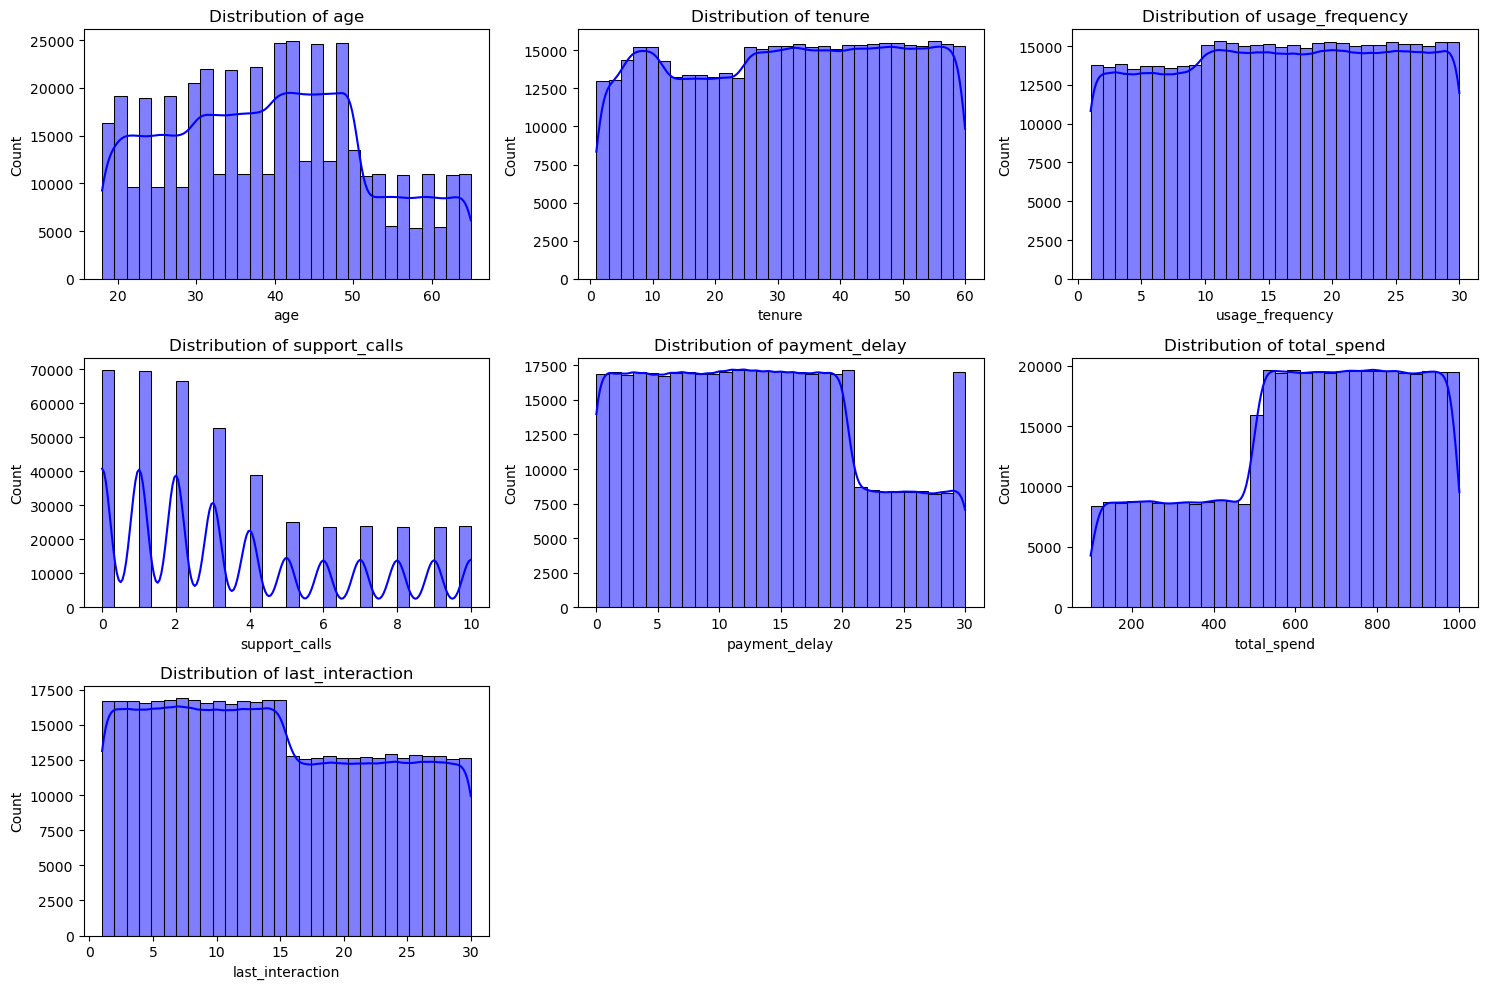

In [16]:
# Plotting data distribution for numeric columns
col_num = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction']


plt.figure(figsize=(15, 10))
for i, col in enumerate(col_num, 1):
    plt.subplot(3, 3, i)  # Adjust grid size if needed
    sns.histplot(train_df[col], bins=30, kde=True, color='blue')  # Histogram with KDE
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

<Axes: xlabel='subscription_type', ylabel='count'>

Text(0.5, 1.0, 'Custmer Churn Distribution by Subscription Type')

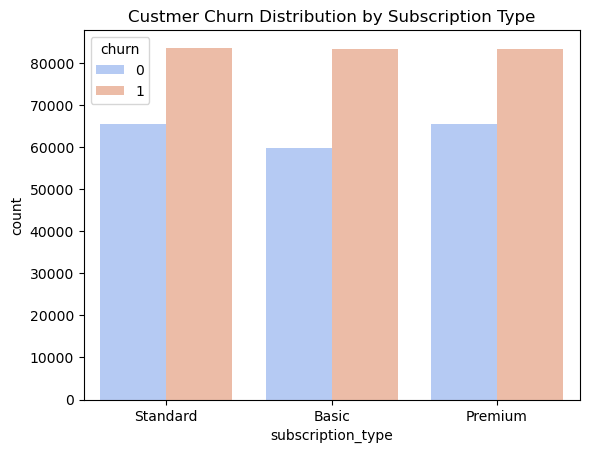

<Axes: xlabel='contract_length', ylabel='count'>

Text(0.5, 1.0, 'Custmer Churn Distribution by Contract Length')

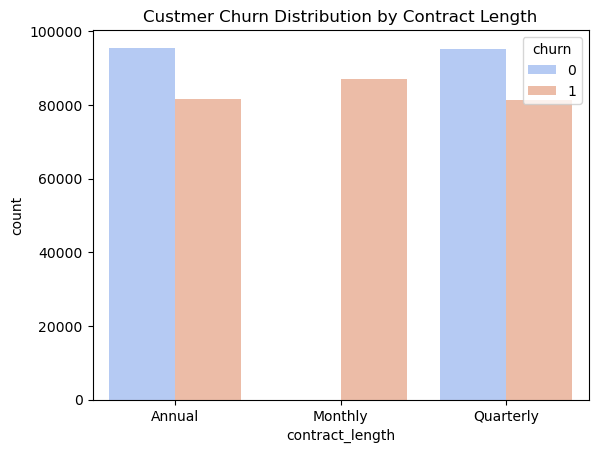

<Axes: xlabel='churn', ylabel='total_spend'>

Text(0.5, 1.0, 'Average Spending Between Churned and Not Churned Customers')

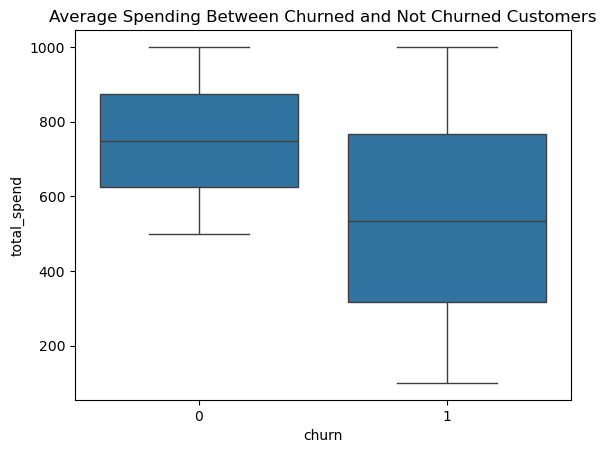

<Axes: xlabel='churn', ylabel='tenure'>

Text(0.5, 1.0, 'Average Tenure Between Churned and Not Churned Customers')

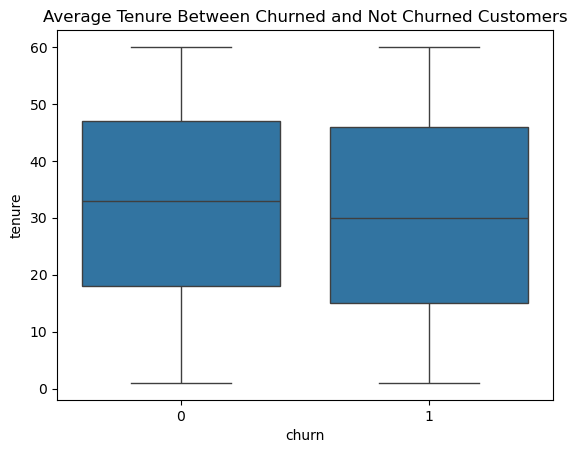

In [17]:
#Subscription Type
sns.countplot(x="subscription_type", hue="churn", data=train_df, palette = "coolwarm")
plt.title("Custmer Churn Distribution by Subscription Type")
plt.show()

#Contract Length
sns.countplot(x="contract_length", hue="churn", data=train_df, palette = "coolwarm")
plt.title("Custmer Churn Distribution by Contract Length")
plt.show()

#Total Spend
sns.boxplot(x="churn", y="total_spend", data=train_df)
plt.title("Average Spending Between Churned and Not Churned Customers")
plt.show()

#Tenure
sns.boxplot(x="churn", y="tenure", data=train_df)
plt.title("Average Tenure Between Churned and Not Churned Customers")
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Payment Delay (Days)')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Payment Delay')

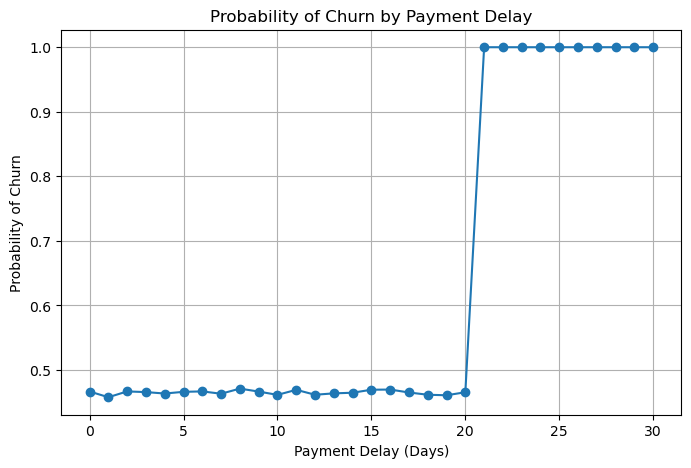

In [18]:
# Grouping by Payment Delay to calculate Churn Probability
churn_prob_1 = train_df.groupby('payment_delay')['churn'].mean()

# Plot Churn Probability vs Payment Delay
plt.figure(figsize=(8,5))
plt.plot(churn_prob_1.index, churn_prob_1.values, marker='o', linestyle='-')
plt.xlabel("Payment Delay (Days)")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Payment Delay")
plt.grid()
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Support Calls')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Support Calls')

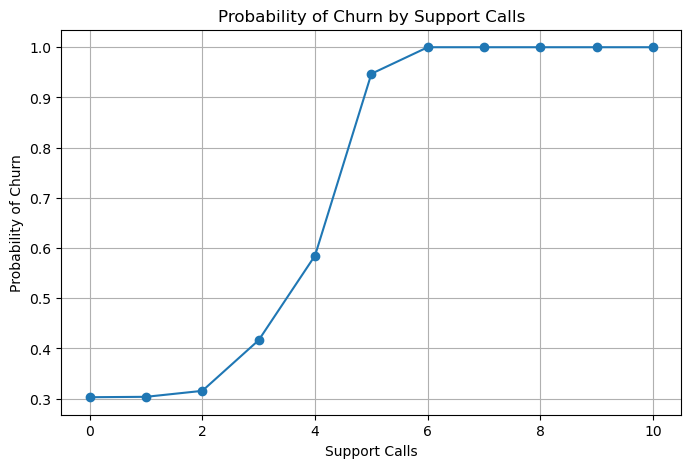

In [19]:
# Grouping by Support calls to calculate Churn Probability
churn_prob_2 = train_df.groupby('support_calls')['churn'].mean()

# Plot Churn Probability vs Support Calls
plt.figure(figsize=(8,5))
plt.plot(churn_prob_2.index, churn_prob_2.values, marker='o', linestyle='-')
plt.xlabel("Support Calls")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Support Calls")
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: >

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'tenure'),
  Text(2.5, 0, 'usage_frequency'),
  Text(3.5, 0, 'support_calls'),
  Text(4.5, 0, 'payment_delay'),
  Text(5.5, 0, 'total_spend'),
  Text(6.5, 0, 'last_interaction'),
  Text(7.5, 0, 'churn')])

Text(0.5, 1.0, 'Correlation Heatmap')

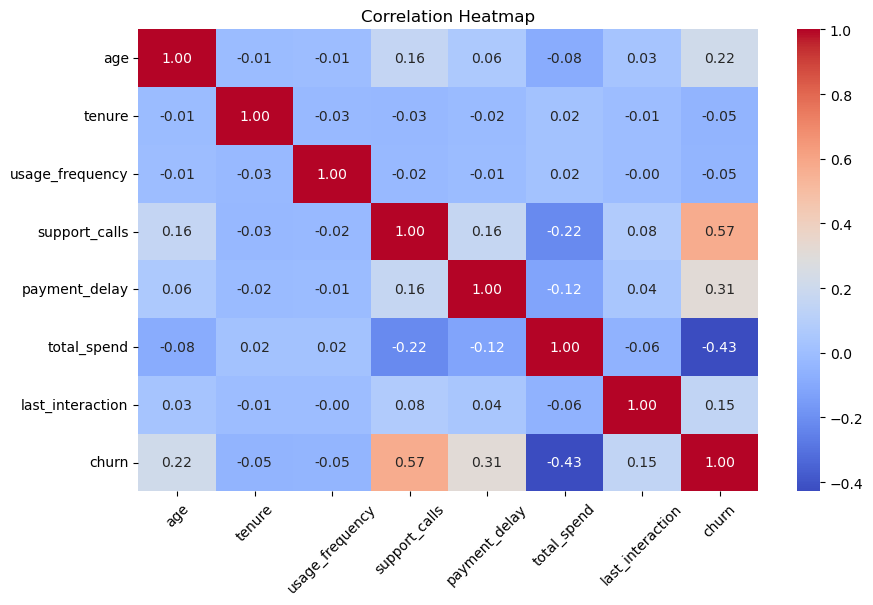

In [20]:
#Correlation between Numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(numeric_only = True), annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation = 45)
plt.title("Correlation Heatmap")
plt.show()

In [21]:
print("Minimum age: {}".format(train_df.age.min()))
print("Maxmum age: {}".format(train_df.age.max()))

Minimum age: 18
Maxmum age: 65


#### **Age Group Segmentation**

<ul>
    <li>Young Adults: 18 - 24 years</li>
    <li>Young Professionals: 25 - 34 years</li>
    <li>Established Adults: 35 - 44 years</li>
    <li>Middle-Aged Consumers: 45 - 54 years</li>
    <li>Seniors: 55 - 65 years</li>
</ul>

In [23]:
#Addition of new column - 'Age Group'
def assign_age_group(age):
    if age < 18:
        return "Minors"
    elif 18 <= age <= 24:
        return "Young Adults"
    elif 25 <= age <= 34:
        return "Young Professionals"
    elif 35 <= age <= 44:
        return "Established Adults"
    elif 45 <= age <= 54:
        return "Middle-Aged Consumers"
    else:
        return "Seniors"

train_df['age_group'] = train_df['age'].apply(assign_age_group)
cols = list(train_df.columns)
train_df = train_df[cols[:-2] + [cols[-1], cols[-2]]]
train_df.head(10)

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,age_group,churn
CustomerID,,,,,,,,,,,,
2.0,30,Female,39,14,5,18,Standard,Annual,932,17,Young Professionals,1
3.0,65,Female,49,1,10,8,Basic,Monthly,557,6,Seniors,1
4.0,55,Female,14,4,6,18,Basic,Quarterly,185,3,Seniors,1
5.0,58,Male,38,21,7,7,Standard,Monthly,396,29,Seniors,1
6.0,23,Male,32,20,5,8,Basic,Monthly,617,20,Young Adults,1
8.0,51,Male,33,25,9,26,Premium,Annual,129,8,Middle-Aged Consumers,1
9.0,58,Female,49,12,3,16,Standard,Quarterly,821,24,Seniors,1
10.0,55,Female,37,8,4,15,Premium,Annual,445,30,Seniors,1
11.0,39,Male,12,5,7,4,Standard,Quarterly,969,13,Established Adults,1


<Axes: xlabel='age', ylabel='Count'>

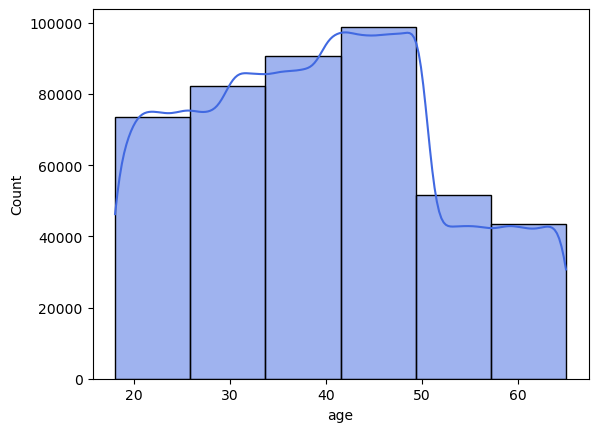

In [24]:
sns.histplot(train_df['age'], bins=6, kde=True, color='royalblue')
plt.show()

<Axes: xlabel='age_group', ylabel='count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Young Professionals'),
  Text(1, 0, 'Seniors'),
  Text(2, 0, 'Young Adults'),
  Text(3, 0, 'Middle-Aged Consumers'),
  Text(4, 0, 'Established Adults')])

Text(0.5, 1.0, 'Customer churn distribution by age group')

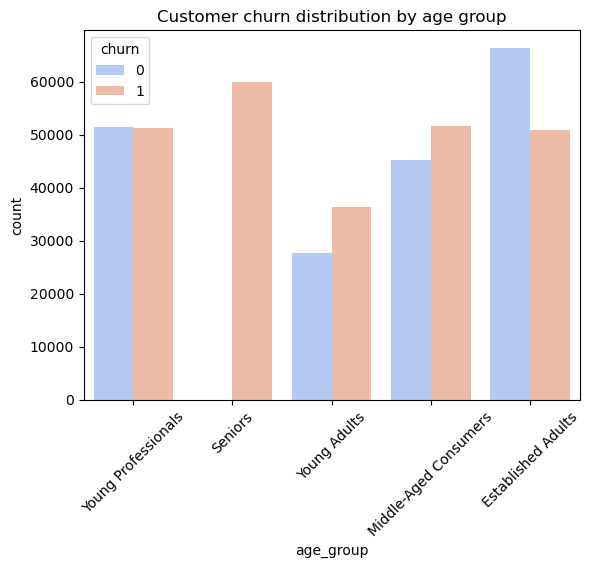

In [25]:
#Customer Segmentation based on age
sns.countplot(x="age_group",hue="churn", data=train_df, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer churn distribution by age group")
plt.show()

<Axes: xlabel='gender', ylabel='count'>

([0, 1], [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

Text(0.5, 1.0, 'Customer churn distribution by Gender')

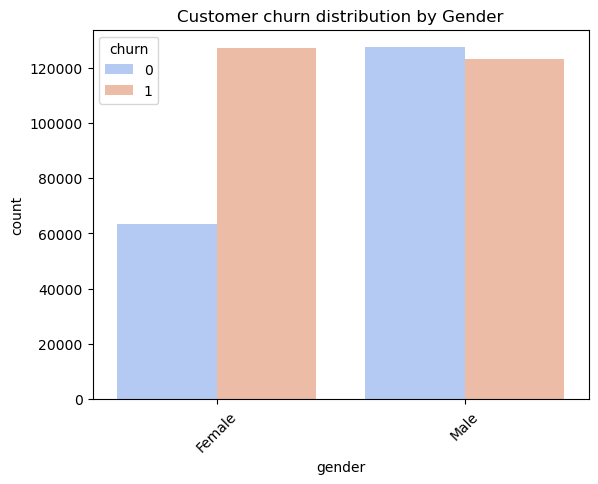

In [26]:
#Customer Segmentation based on age
sns.countplot(x="gender",hue="churn", data=train_df, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer churn distribution by Gender")
plt.show()

## Data Preparation

In [28]:
# Storing the Train and Test set in separate Data Frames

df_train = train_df.copy().drop(columns=["age_group"])
df_test = test_df.copy()

#Column Names
df_test.columns = df_test.columns.str.lower().str.replace(" ", "_")

#Pre processcing Categorical columns
categorical_features = ["gender", "subscription_type", "contract_length"]
df_train = pd.get_dummies(df_train, columns=categorical_features, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical_features, drop_first=True)

# Separate features and target
X_train = df_train.drop(columns=["churn"])
y_train = df_train["churn"]
X_test = df_test.drop(columns=["churn"])
y_test = df_test["churn"]

In [29]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# Compute sample weights for class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_balanced)

<Figure size 1200x600 with 0 Axes>

<Axes: >

([<matplotlib.patches.Wedge at 0x142bbf0b0>,
 [Text(-1.075644810680109, -0.23019174888981714, '1'),
  Text(1.075644810680109, 0.230191748889817, '0')],
 [Text(-0.5867153512800594, -0.12555913575808206, '56.7%'),
  Text(0.5867153512800594, 0.125559135758082, '43.3%')])

Text(0.5, 1.0, 'Original Class Distribution (Before SMOTE)')

<Axes: >

([<matplotlib.patches.Wedge at 0x127f59160>,
 [Text(-1.1, 1.3471114790620887e-16, '1'),
  Text(1.1, -2.6942229581241775e-16, '0')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.6, -1.4695761589768238e-16, '50.0%')])

Text(0.5, 1.0, 'Balanced Class Distribution (After SMOTE)')

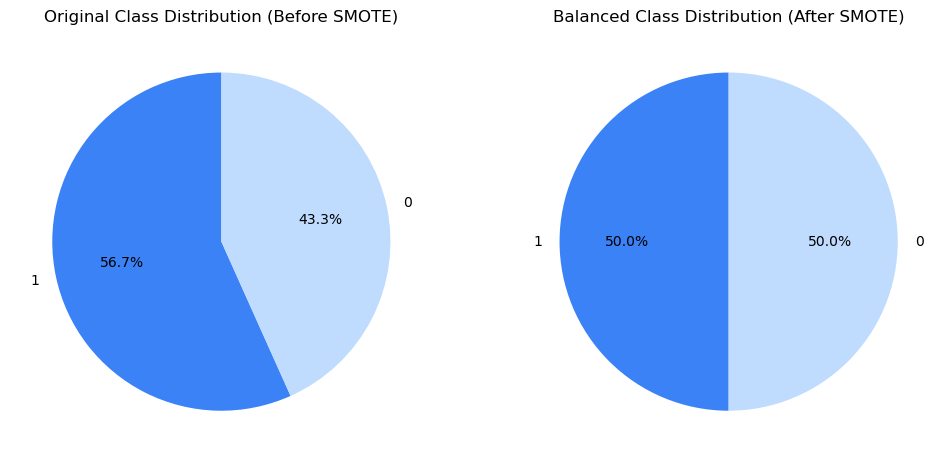

In [30]:
import matplotlib.pyplot as plt
from collections import Counter

# Before SMOTE (Original class distribution)
original_class_dist = Counter(y_train)

# After SMOTE (Balanced class distribution)
smote_class_dist = Counter(y_train_balanced)

# Plotting the original class distribution
plt.figure(figsize=(12, 6))

# Subplot for original class distribution
plt.subplot(1, 2, 1)
plt.pie(original_class_dist.values(), labels=original_class_dist.keys(), autopct='%1.1f%%', startangle=90, colors=['#3B82F6', '#BFDBFE'])
plt.title("Original Class Distribution (Before SMOTE)")

# Subplot for balanced class distribution
plt.subplot(1, 2, 2)
plt.pie(smote_class_dist.values(), labels=smote_class_dist.keys(), autopct='%1.1f%%', startangle=90, colors=['#3B82F6', '#BFDBFE'])
plt.title("Balanced Class Distribution (After SMOTE)")

# Show the plot
plt.show()

In [31]:
# Standardize features for Logistic Regression and MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Model Development

### Logistic Regression

In [33]:
logreg = LogisticRegression(max_iter = 1000)

#Defining the hyperparameter
lr_param_grid = {
     'penalty': ['l1', 'l2'],
    'C': [0.001, 0.005, 0.01, 0.1, 1],
    'solver': ['saga', 'lbfgs']
            }
lr_grid = GridSearchCV(logreg, param_grid = lr_param_grid, cv = 5, scoring = "accuracy", n_jobs = -1, return_train_score = True)
lr_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.005, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

In [34]:
#Best parameter for Logistic Regression
lr_best_param = lr_grid.best_params_
print("Best parameter for Logistic Regression from {} : {}".format(lr_grid.__class__.__name__,lr_best_param))

#Best Model for Logistic Regression
lr_best_model = lr_grid.best_estimator_

Best parameter for Logistic Regression from GridSearchCV : {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}



Top 10 Features by Importance:
                   Feature  Coefficient  Absolute Coefficient
   contract_length_Monthly     2.535624              2.535624
             support_calls     2.224370              2.224370
               total_spend    -1.351722              1.351722
             payment_delay     0.861098              0.861098
          last_interaction     0.472860              0.472860
               gender_Male    -0.456105              0.456105
                       age     0.380916              0.380916
                    tenure    -0.089140              0.089140
           usage_frequency    -0.083789              0.083789
subscription_type_Standard     0.073956              0.073956


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 5 artists>

Text(0.5, 0, 'Weights')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 5 Most Important Features')

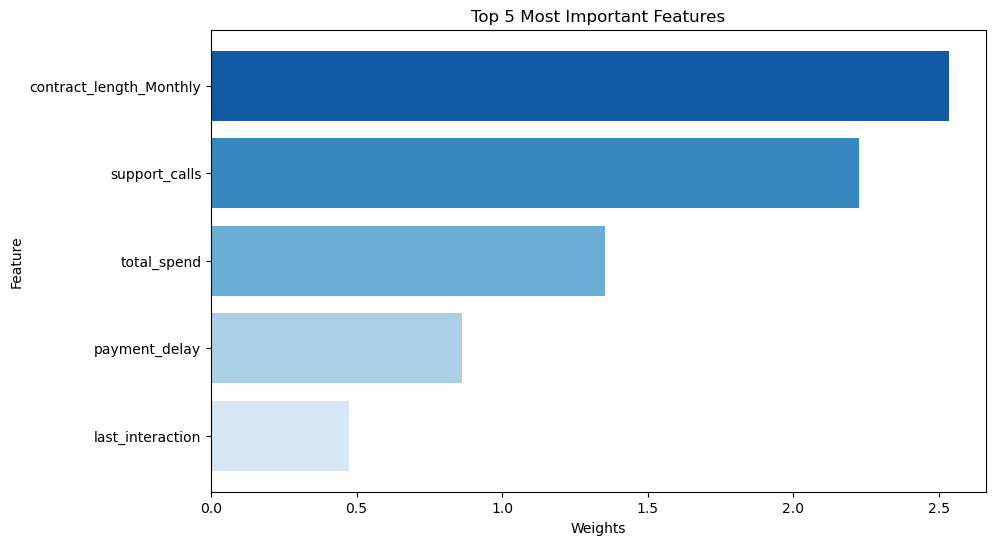

In [35]:
# Get the coefficients directly from the model
coefficients = lr_best_model.coef_[0]

# If not using a pipeline, get feature names directly from the DataFrame
feature_names = X_train_balanced.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Add absolute coefficient for sorting
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()

# Sort by absolute value of coefficients (descending)
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False).reset_index(drop=True)

# Display top 10 features
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10).to_string(index=False))

colors = sns.color_palette("Blues", n_colors=5)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:5][::-1],
         feature_importance['Absolute Coefficient'][:5][::-1],
         color=colors)

plt.xlabel('Weights')
plt.ylabel('Feature')
plt.title('Top 5 Most Important Features')
plt.show()

In [36]:
#Evaluation on Training Set
y_train_lrpred = lr_best_model.predict(X_train_scaled)
lr_train_acc = accuracy_score(y_train_balanced, y_train_lrpred)
lr_train_cr = classification_report(y_train_balanced, y_train_lrpred)

#Evaluation on Test Set
y_test_lrpred = lr_best_model.predict(X_test_scaled)
lr_test_acc = accuracy_score(y_test, y_test_lrpred)
lr_test_cr = classification_report(y_test, y_test_lrpred)

print("Training Set Accuracy (Logistic Regression): {:.4f}".format(lr_train_acc))
print("Test Set Accuracy (Logistic Regression): {:.4f}".format(lr_test_acc))
print("Classification Report for Training Set (Logistic Regression):\n",lr_train_cr)
print("Classification Report for Test Set (Logistic Regression):\n",lr_test_cr)

Training Set Accuracy (Logistic Regression): 0.9032
Test Set Accuracy (Logistic Regression): 0.5801
Classification Report for Training Set (Logistic Regression):
               precision    recall  f1-score   support

           0       0.88      0.93      0.91    249999
           1       0.93      0.87      0.90    249999

    accuracy                           0.90    499998
   macro avg       0.90      0.90      0.90    499998
weighted avg       0.90      0.90      0.90    499998

Classification Report for Test Set (Logistic Regression):
               precision    recall  f1-score   support

           0       0.95      0.21      0.35     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374



<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression')

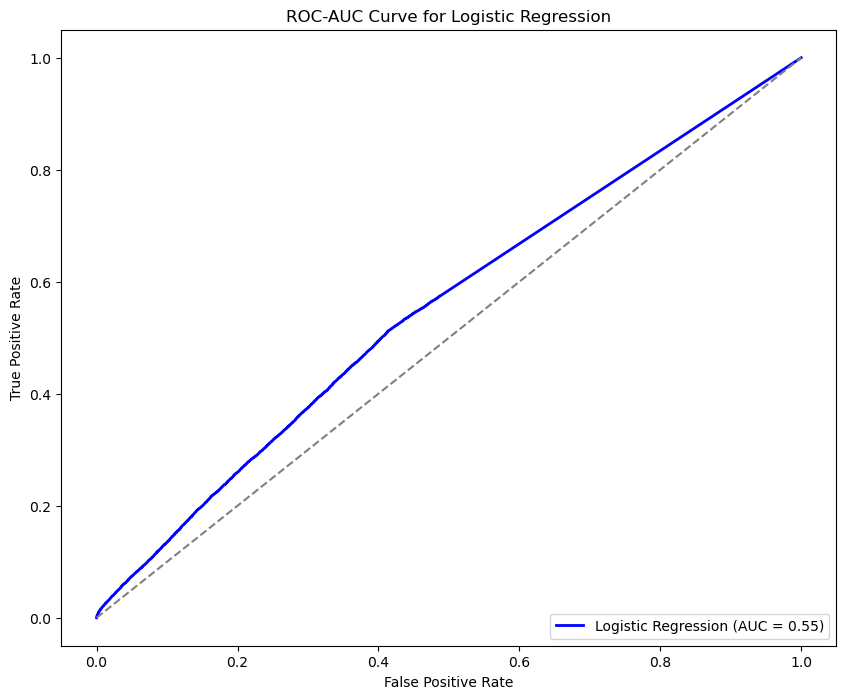

In [37]:
y_prob_lr = lr_best_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

#Plot the ROC_AUC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

True Positives (TP): 30121
True Negatives (TN): 7222
False Positives (FP): 26659
False Negatives (FN): 372


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Test Set (Logistic Regression)')

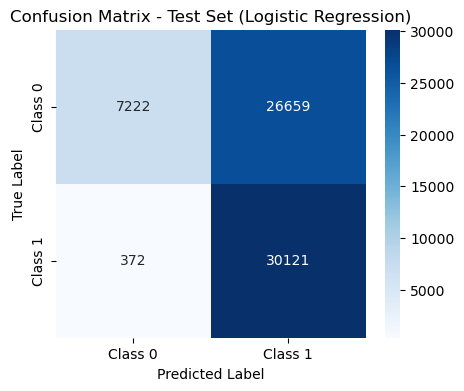

In [38]:
# Confusion Matrix for Test Set
lr_cm_test = confusion_matrix(y_test, y_test_lrpred)

# Print the extracted values
TN, FP, FN, TP = lr_cm_test.ravel()
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

#Plot the Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(lr_cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set (Logistic Regression)")
plt.show()

### Decision Tree

In [40]:
# Defining a baseline Decision Tree model
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train, y_train)

# Make predictions
y_train_pred_dt1 = dt_model.predict(X_train)
y_test_pred_dt1 = dt_model.predict(X_test)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_dt1))
print("Classification Report (Train):\n", classification_report(y_train, y_train_pred_dt1))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_dt1))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_dt1))

DecisionTreeClassifier()

Training Accuracy: 1.0
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    190833
           1       1.00      1.00      1.00    249999

    accuracy                           1.00    440832
   macro avg       1.00      1.00      1.00    440832
weighted avg       1.00      1.00      1.00    440832

Test Accuracy: 0.5033398577065274

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted Label')

Text(50.722222222222214, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

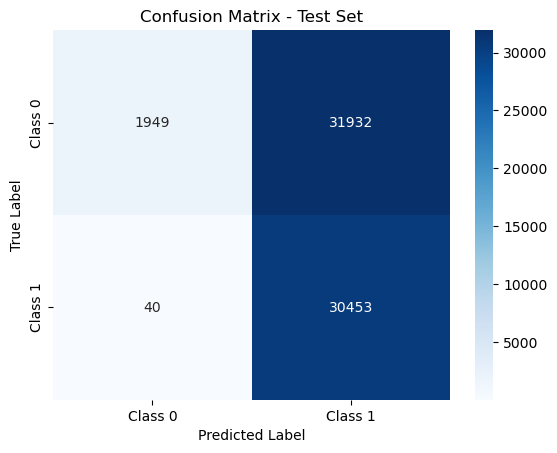

In [41]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_dt1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve for Decision Tree Classifier')

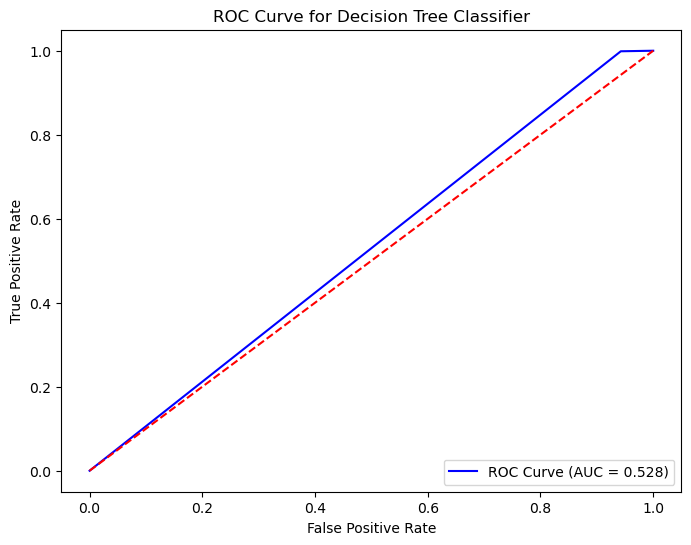

In [42]:
# Get predicted probabilities instead of class labels
y_test_probs = dt_model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Compute AUC score
roc_auc = roc_auc_score(y_test, y_test_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Predicted Probability of Class 1')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Predicted Probabilities for Class 1')

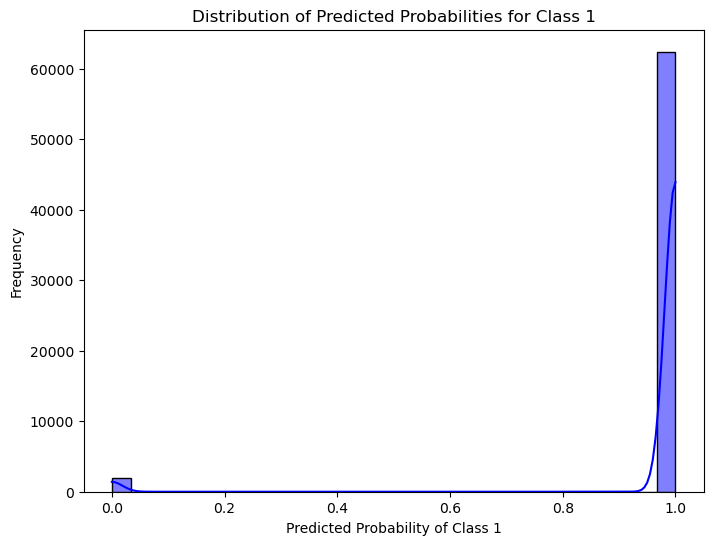

In [43]:
# plotting probability distribution
plt.figure(figsize=(8, 6))

sns.histplot(y_test_probs, bins=30, kde=True, color='blue')
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.show()

In [44]:
# Define hyperparameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [40, 50, 60],
    'ccp_alpha': np.linspace(0.08, 0.2, 10)
}

# Perform grid search
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid,
                    cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': array([0.08      , 0.09333333, 0.10666667, 0.12      , 0.13333333,
       0.14666667, 0.16      , 0.17333333, 0.18666667, 0.2       ]),
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [40, 50, 60],
                         'min_samples_split': [30, 40, 50]},
             return_train_score=True, scoring='accuracy')

Best Parameters: {'ccp_alpha': 0.08, 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split': 30}


In [45]:
# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report (Train):\n", classification_report(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.8718264554297329
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.77      0.99      0.87    190833
           1       0.99      0.78      0.87    249999

    accuracy                           0.87    440832
   macro avg       0.88      0.89      0.87    440832
weighted avg       0.90      0.87      0.87    440832

Test Accuracy: 0.6083356634666169

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.32      0.46     33881
           1       0.55      0.93      0.69     30493

    accuracy                           0.61     64374
   macro avg       0.70      0.62      0.58     64374
weighted avg       0.70      0.61      0.57     64374



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted Label')

Text(50.722222222222214, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

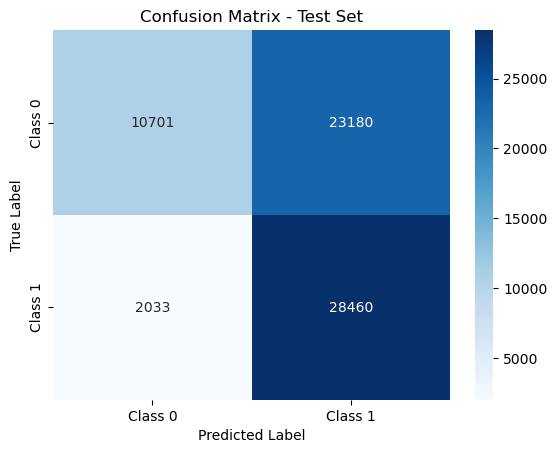

In [46]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve for Decision Tree Classifier')

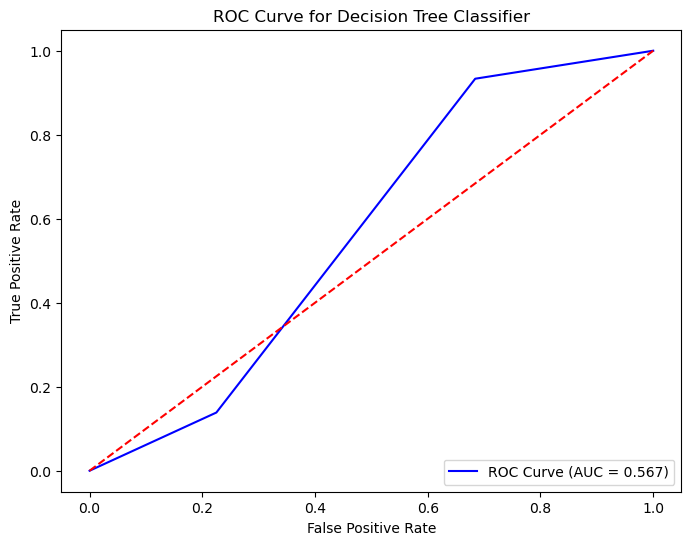

In [47]:
# Get predicted probabilities instead of class labels
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Compute AUC score
roc_auc = roc_auc_score(y_test, y_test_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Predicted Probability of Class 1')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Predicted Probabilities for Class 1')

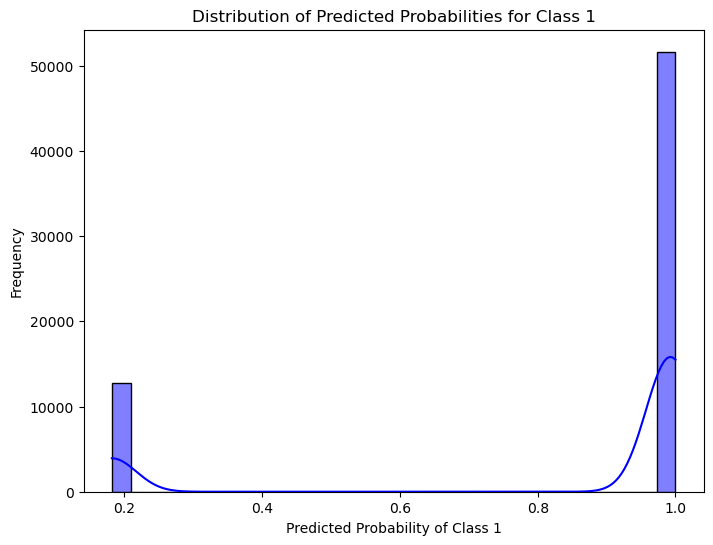

In [48]:
# plotting probability distribution
plt.figure(figsize=(8, 6))

sns.histplot(y_test_probs, bins=30, kde=True, color='blue')
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.show()

### Gradient Boosting

In [50]:
# Define hyperparameter grid
gb_param_grid = {
    "n_estimators": [10, 15, 25],  # Further reduced estimators
    "learning_rate": [0.002, 0.005],
    "max_depth": [1],
    "subsample": [0.6, 0.7],
    "min_samples_split": [50, 100]
}
# Grid search with cross-validation
gb_model = GradientBoostingClassifier(random_state=0)
gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
gb_grid.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.002, 0.005], 'max_depth': [1],
                         'min_samples_split': [50, 100],
                         'n_estimators': [10, 15, 25],
                         'subsample': [0.6, 0.7]},
             scoring='accuracy', verbose=2)

In [51]:
# Best model
gb_best_model = gb_grid.best_estimator_
print("Best Parameters:", gb_grid.best_params_)

# Train accuracy
y_train_pred = gb_best_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report (Train):\n", classification_report(y_train, y_train_pred))

# Test accuracy
y_test_pred = gb_best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

Best Parameters: {'learning_rate': 0.002, 'max_depth': 1, 'min_samples_split': 50, 'n_estimators': 10, 'subsample': 0.6}
Training Accuracy: 0.7522820484901278
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.64      0.99      0.78    190833
           1       0.99      0.57      0.72    249999

    accuracy                           0.75    440832
   macro avg       0.81      0.78      0.75    440832
weighted avg       0.84      0.75      0.75    440832

Test Accuracy: 0.6611054152297512
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.75      0.54      0.63     33881
           1       0.61      0.79      0.69     30493

    accuracy                           0.66     64374
   macro avg       0.68      0.67      0.66     64374
weighted avg       0.68      0.66      0.66     64374



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted Label')

Text(50.722222222222214, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

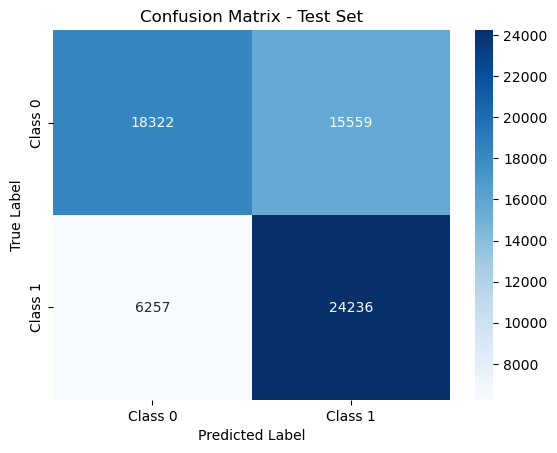

In [52]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve - Gradient Boosting')

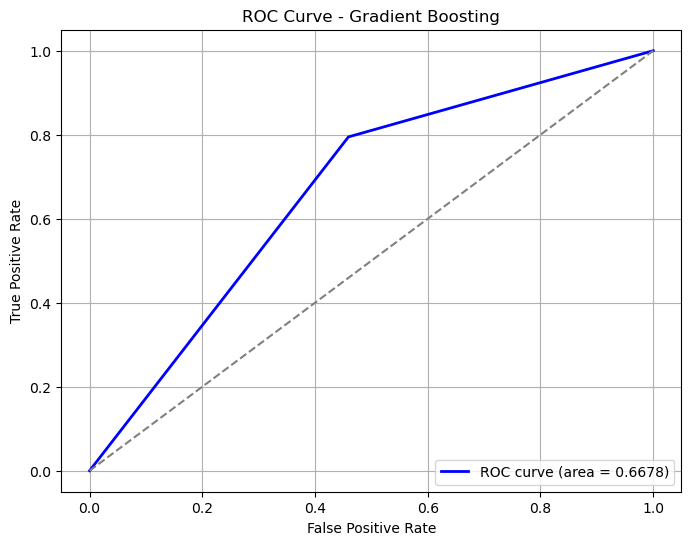

In [53]:
# ROC Curve
y_test_probs = gb_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = {:.4f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### MLP

In [55]:
# Define hyperparameter grid for MLP
mlp_param_grid = {
    "hidden_layer_sizes": [(128,), (64,)],  # Reduce complexity
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [100.0, 500.0, 1000.0],  # Increase regularization
    "max_iter": [500, 1000],  # More iterations for convergence
}

# Grid search with cross-validation
mlp_model = MLPClassifier(random_state=42, early_stopping=True, learning_rate_init=0.001)

mlp_grid = GridSearchCV(mlp_model, mlp_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
mlp_grid.fit(X_train_scaled, y_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': [100.0, 500.0, 1000.0],
                         'hidden_layer_sizes': [(128,), (64,)],
                         'max_iter': [500, 1000], 'solver': ['adam']},
             scoring='accuracy', verbose=2)

In [56]:
#Results after choosing the optimal threshold

#Best Model
mlp_best_model = mlp_grid.best_estimator_

# Train accuracy
y_train_pred = mlp_best_model.predict(X_train_scaled)
print("Training Accuracy:", accuracy_score(y_train_balanced, y_train_pred))
print("Classification Report (Train):\n", classification_report(y_train_balanced, y_train_pred))

# Get churn probabilities
y_probs = mlp_best_model.predict_proba(X_test_scaled)[:, 1]

# Compute precision-recall vs. threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the optimal threshold (where precision ≈ recall)
optimal_idx = np.argmin(np.abs(precisions - recalls))
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Apply new threshold
y_test_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

# Test accuracy with adjusted threshold
test_acc = accuracy_score(y_test, y_test_pred_adjusted)
print("Test Accuracy (Adjusted Threshold):", test_acc)
print("Classification Report (Test, Adjusted Threshold):\n", classification_report(y_test, y_test_pred_adjusted))

Training Accuracy: 0.8417593670374681
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.76      1.00      0.86    249999
           1       0.99      0.69      0.81    249999

    accuracy                           0.84    499998
   macro avg       0.88      0.84      0.84    499998
weighted avg       0.88      0.84      0.84    499998

Optimal Threshold: 0.5020628289859023
Test Accuracy (Adjusted Threshold): 0.6802435765992482
Classification Report (Test, Adjusted Threshold):
               precision    recall  f1-score   support

           0       0.70      0.70      0.70     33881
           1       0.66      0.66      0.66     30493

    accuracy                           0.68     64374
   macro avg       0.68      0.68      0.68     64374
weighted avg       0.68      0.68      0.68     64374



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted Label')

Text(50.722222222222214, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Adjusted Threshold')

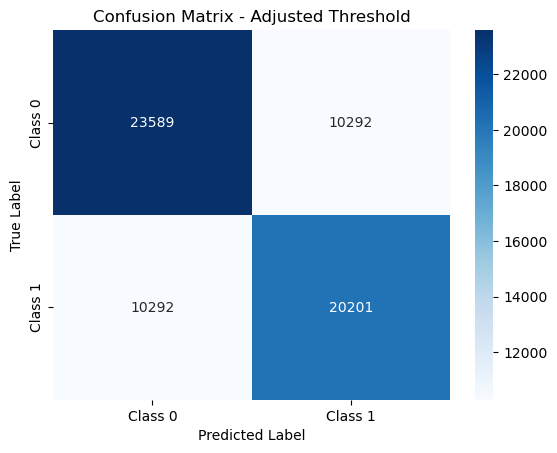

In [57]:
# Confusion matrix with adjusted threshold
cm = confusion_matrix(y_test, y_test_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Adjusted Threshold")
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve - MLP Classifier')

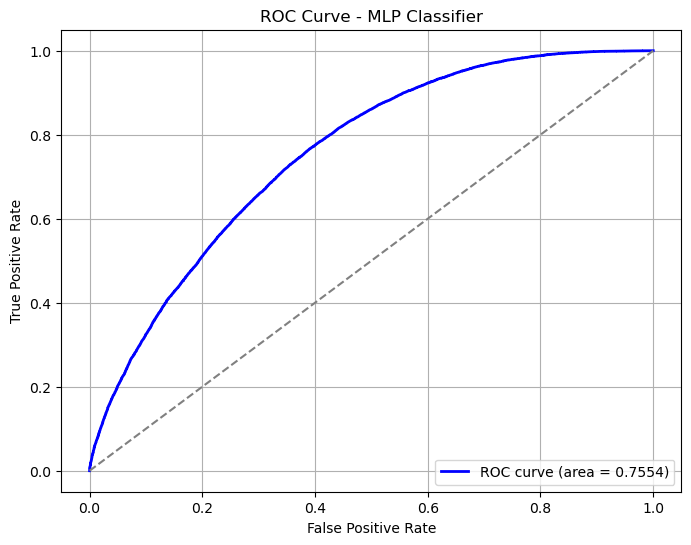

In [58]:
# ROC Curve
y_test_probs = mlp_best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = {:.4f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 12 artists>

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Importance Score')

Text(0.5, 1.0, 'Feature Importance in MLP (Permutation Importance)')

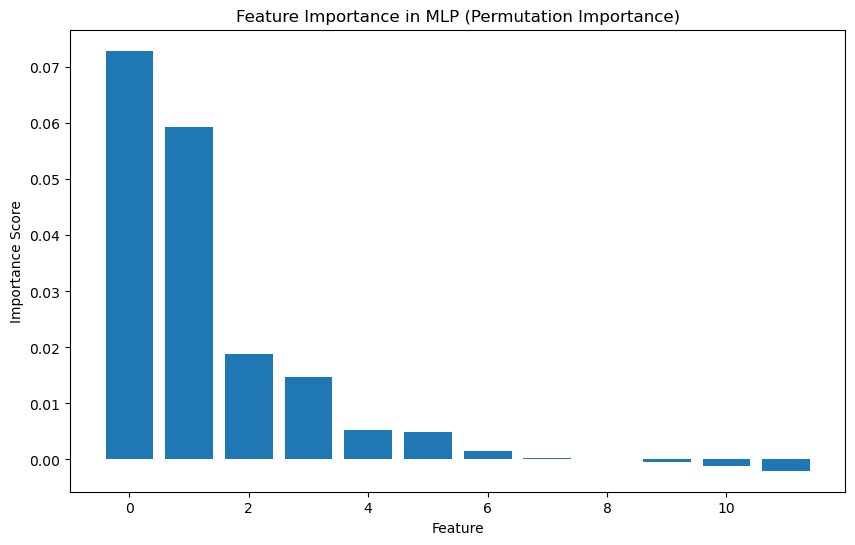

In [59]:
feature_names = train_df.drop(columns=["churn"]).columns

# Compute feature importance using permutation importance
perm_importance = permutation_importance(mlp_best_model, X_test_scaled, y_test, scoring="accuracy", n_repeats=10, random_state=42)

# Extract importance values
importances = perm_importance.importances_mean
sorted_idx = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in MLP (Permutation Importance)")
plt.show()